In [10]:
import pandas as pd
from prophet import Prophet
import joblib
import os
import matplotlib.pyplot as plt

In [29]:
%matplotlib inline

In [8]:
%pip install ipywidgets

  Using cached ipywidgets-8.1.8-py3-none-any.whl.metadata (2.4 kB)
Using cached ipywidgets-8.1.8-py3-none-any.whl (139 kB)
Note: you may need to restart the kernel to use updated packages.


In [9]:
%pip install notebook
%pip install jupyterlab_widgets

   ---------------------------------------- 0.0/14.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/14.3 MB ? eta -:--:--
    --------------------------------------- 0.3/14.3 MB ? eta -:--:--
   -- ------------------------------------- 1.0/14.3 MB 3.4 MB/s eta 0:00:04
   ------- -------------------------------- 2.6/14.3 MB 5.2 MB/s eta 0:00:03
   ------------ --------------------------- 4.5/14.3 MB 6.4 MB/s eta 0:00:02
   ------------------ --------------------- 6.6/14.3 MB 7.1 MB/s eta 0:00:02
   ----------------------- ---------------- 8.4/14.3 MB 7.5 MB/s eta 0:00:01
   ---------------------------- ----------- 10.2/14.3 MB 7.8 MB/s eta 0:00:01
   -------------------------------- ------- 11.8/14.3 MB 7.7 MB/s eta 0:00:01
   -------------------------------------- - 13.9/14.3 MB 7.9 MB/s eta 0:00:01
   ---------------------------------------- 14.3/14.3 MB 7.6 MB/s  0:00:02
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart 

In [2]:
!pip install prophet

     ---------------------------------------- 0.0/50.1 kB ? eta -:--:--
     --------------- ---------------------- 20.5/50.1 kB 330.3 kB/s eta 0:00:01
     ----------------------- -------------- 30.7/50.1 kB 435.7 kB/s eta 0:00:01
     ------------------------------- ------ 41.0/50.1 kB 281.8 kB/s eta 0:00:01
     -------------------------------------- 50.1/50.1 kB 255.4 kB/s eta 0:00:00
     ---------------------------------------- 0.0/57.7 kB ? eta -:--:--
     ---------------------------------------- 57.7/57.7 kB 1.5 MB/s eta 0:00:00
   ---------------------------------------- 0.0/12.1 MB ? eta -:--:--
   ---------------------------------------- 0.1/12.1 MB ? eta -:--:--
   ---------------------------------------- 0.1/12.1 MB ? eta -:--:--
    --------------------------------------- 0.2/12.1 MB 1.3 MB/s eta 0:00:10
    --------------------------------------- 0.2/12.1 MB 1.5 MB/s eta 0:00:08
    --------------------------------------- 0.3/12.1 MB 1.1 MB/s eta 0:00:11
   - ----------


[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
!pip show prophet

Name: prophet
Version: 1.2.1
Summary: Automatic Forecasting Procedure
Home-page: 
Author: 
Author-email: "Sean J. Taylor" <sjtz@pm.me>, Ben Letham <bletham@fb.com>
License: MIT
Location: C:\Users\HT\Documents\Projects\agriroute_data\hackproject_env\Lib\site-packages
Requires: cmdstanpy, holidays, importlib_resources, matplotlib, numpy, pandas, tqdm
Required-by: 


In [4]:
!python -m pip install --upgrade pip

   ---------------------------------------- 0.0/1.8 MB ? eta -:--:--
    --------------------------------------- 0.0/1.8 MB ? eta -:--:--
    --------------------------------------- 0.0/1.8 MB ? eta -:--:--
   - -------------------------------------- 0.1/1.8 MB 558.5 kB/s eta 0:00:04
   -- ------------------------------------- 0.1/1.8 MB 655.4 kB/s eta 0:00:03
   -- ------------------------------------- 0.1/1.8 MB 502.0 kB/s eta 0:00:04
   ----- ---------------------------------- 0.2/1.8 MB 808.4 kB/s eta 0:00:02
   ----- ---------------------------------- 0.2/1.8 MB 808.4 kB/s eta 0:00:02
   ------- -------------------------------- 0.3/1.8 MB 846.5 kB/s eta 0:00:02
   ---------- ----------------------------- 0.5/1.8 MB 1.1 MB/s eta 0:00:02
   ------------ --------------------------- 0.6/1.8 MB 1.2 MB/s eta 0:00:02
   ----------------- ---------------------- 0.8/1.8 MB 1.5 MB/s eta 0:00:01
   ----------------------- ---------------- 1.0/1.8 MB 1.9 MB/s eta 0:00:01
   ------------------

In [5]:
!pip install prophet

In [15]:
prices = pd.read_csv("agriroute_data/market_prices.csv")

In [16]:
prices['ds'] = pd.to_datetime(prices['date'] + '-01', errors='coerce')

In [17]:
prices = prices[['ds', 'market', 'crop', 'price_per_100kg_etb']].dropna()

In [18]:
prices['price_per_100kg_etb'] = pd.to_numeric(prices['price_per_100kg_etb'], errors='coerce')
prices = prices.dropna(subset=['price_per_100kg_etb'])

In [19]:
os.makedirs("models", exist_ok=True)
forecast_results = {}

In [20]:
crops = prices['crop'].unique()
markets = prices['market'].unique()

In [21]:
for crop in crops:
    for market in markets:
        key = f"{crop}_{market.replace(' ', '_')}"
        df = prices[(prices['crop'] == crop) & (prices['market'] == market)][['ds', 'price_per_100kg_etb']].copy()
        df = df.rename(columns={'price_per_100kg_etb': 'y'})

        if len(df) < 12:
            print(f"Skipping {key} — not enough data points ({len(df)})")
            continue

        model = Prophet(
            yearly_seasonality=True,
            weekly_seasonality=False,
            daily_seasonality=False,
            changepoint_prior_scale=0.07
        )
        # for holidays times
        try:
            model.add_country_holidays(country_name='ET')
        except:
            pass

        model.fit(df)
        joblib.dump(model, f"models/prophet_{key}.pkl")

        # this one forecasts the  next 6 months
        future = model.make_future_dataframe(periods=6, freq='MS')
        forecast = model.predict(future)

        result = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(6).copy()
        result['ds'] = result['ds'].dt.strftime('%Y-%m')
        forecast_results[key] = result

print("\nAll Prophet models trained and saved successfully!\n")

23:45:59 - cmdstanpy - INFO - Chain [1] start processing
23:46:00 - cmdstanpy - INFO - Chain [1] done processing
23:46:00 - cmdstanpy - INFO - Chain [1] start processing
23:46:00 - cmdstanpy - INFO - Chain [1] done processing
23:46:01 - cmdstanpy - INFO - Chain [1] start processing
23:46:01 - cmdstanpy - INFO - Chain [1] done processing
23:46:01 - cmdstanpy - INFO - Chain [1] start processing
23:46:02 - cmdstanpy - INFO - Chain [1] done processing
23:46:02 - cmdstanpy - INFO - Chain [1] start processing
23:46:02 - cmdstanpy - INFO - Chain [1] done processing
23:46:02 - cmdstanpy - INFO - Chain [1] start processing
23:46:03 - cmdstanpy - INFO - Chain [1] done processing
23:46:03 - cmdstanpy - INFO - Chain [1] start processing
23:46:04 - cmdstanpy - INFO - Chain [1] done processing
23:46:04 - cmdstanpy - INFO - Chain [1] start processing
23:46:04 - cmdstanpy - INFO - Chain [1] done processing
23:46:04 - cmdstanpy - INFO - Chain [1] start processing
23:46:05 - cmdstanpy - INFO - Chain [1]


All Prophet models trained and saved successfully!



In [22]:
def predict_crop_price(crop, market, months_ahead=3):
    """
    Predicts future prices for a specific crop-market pair using a trained Prophet model we've buil before.
    """
    key = f"{crop}_{market.replace(' ', '_')}"
    model_path = f"models/prophet_{key}.pkl"

    if not os.path.exists(model_path):
        print(f" Model not found for {key}. Train it first.")
        return None

    model = joblib.load(model_path)
    future = model.make_future_dataframe(periods=months_ahead, freq='MS')
    forecast = model.predict(future)

    result = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(months_ahead).copy()
    result['ds'] = result['ds'].dt.strftime('%Y-%m')
    result = result.round(2)

    return result.to_dict('records')

In [23]:
example = predict_crop_price('Teff', 'Addis Ababa', months_ahead=6)

if example:
    print("Teff Price Forecast (Addis Ababa) - Next 6 Months:")
    for m in example:
        print(f"{m['ds']}: {m['yhat']:.0f} ETB/100kg "
              f"(95% CI: {m['yhat_lower']:.0f}–{m['yhat_upper']:.0f})")

Teff Price Forecast (Addis Ababa) - Next 6 Months:
2024-12: 13559 ETB/100kg (95% CI: 13515–13603)
2025-01: 16142 ETB/100kg (95% CI: 16097–16189)
2025-02: 13117 ETB/100kg (95% CI: 13071–13161)
2025-03: 14112 ETB/100kg (95% CI: 14069–14158)
2025-04: 14604 ETB/100kg (95% CI: 14558–14649)
2025-05: 14436 ETB/100kg (95% CI: 14388–14486)


## Plot Forcast 

In [30]:
def plot_forecast(crop, market):
    """
    Plots forecast for a given crop and market.
    """
    key = f"{crop}_{market.replace(' ', '_')}"
    model_path = f"models/prophet_{key}.pkl"

    if not os.path.exists(model_path):
        print(f"⚠️ No model found for {key}.")
        return

    model = joblib.load(model_path)
    future = model.make_future_dataframe(periods=6, freq='MS')
    forecast = model.predict(future)

    fig = model.plot(forecast)
    plt.title(f"{crop} Price Forecast — {market}")
    plt.ylabel("Price (ETB per 100kg)")
    plt.xlabel("Date")
    plt.tight_layout()
    plt.show()

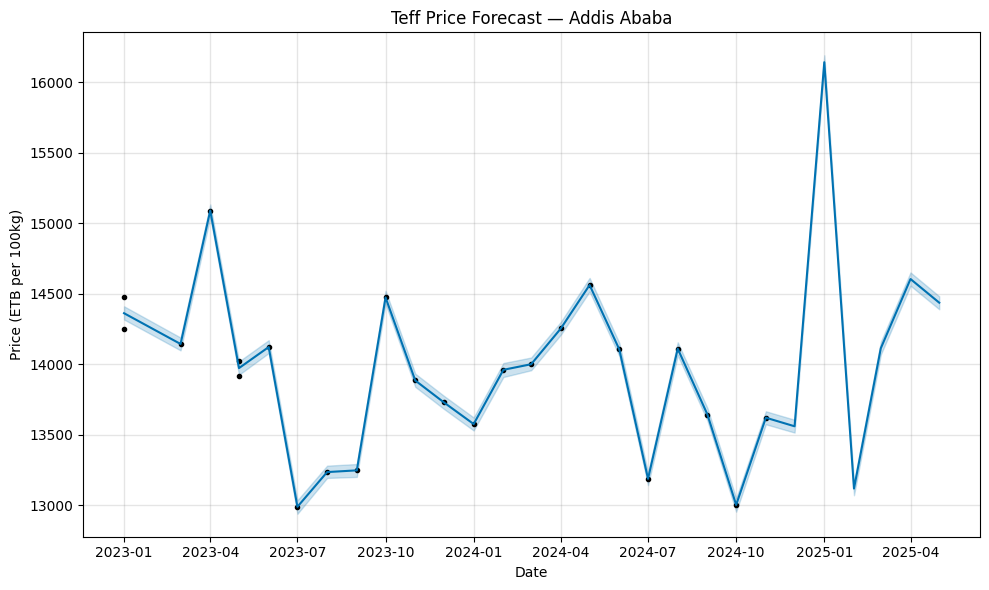

In [31]:
plot_forecast('Teff', 'Addis Ababa')

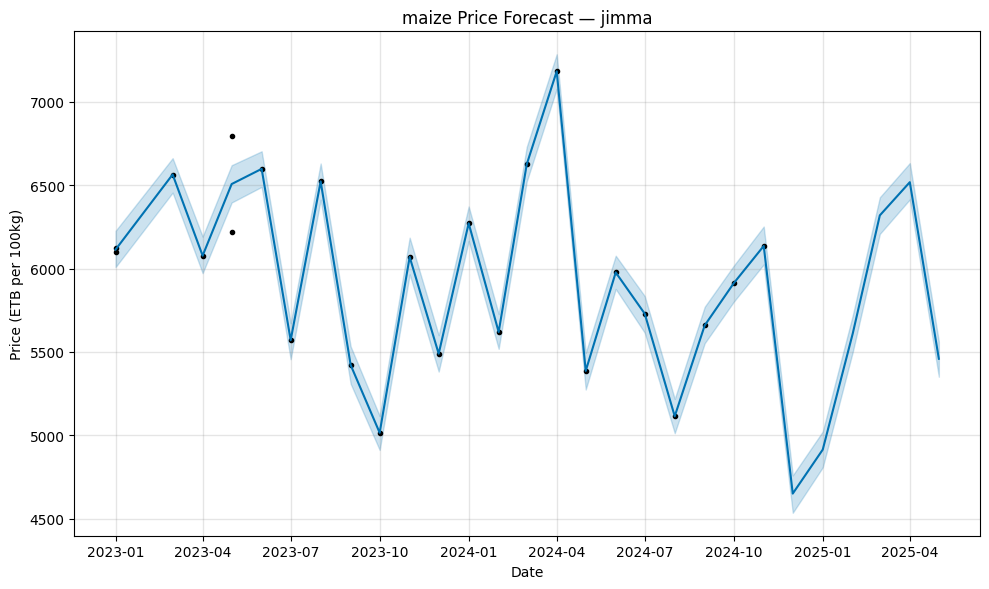

In [34]:
plot_forecast('maize', 'jimma')